# Meta Learner

Conditional Average Treatment Effect (heterogeneous treatment effects)

$$
\text{CATE} = \tau(x)
:= \mathbb{E}[Y^{(1)}-Y^{(0)} \mid X=x]
$$

の推定のため、複数の予測モデルを構築する手法

論文： [Künzel, et al. (2019). Metalearners for estimating heterogeneous treatment effects using machine learning.](https://www.pnas.org/doi/full/10.1073/pnas.1804597116)

:::{card} 記法について

- 個体$i$
- 共変量（covariates）または特徴量（features）：$X_i \in \mathcal{X} \subset \mathbb{R}^{m}$
- 潜在的結果（potential outcomes） $Y_i^{(0)}, Y_i^{(1)} \in \mathbb{R}$
- 処置割当（assignment） $D_i \in \{0, 1\}$
- 個体$i$のデータ：$(X_i, D_i, Y_i^{(0)}, Y_i^{(1)})$
- 個体$i$の観測データ：$(X_i, D_i, Y_i)$
- 観測された結果：$Y_i = D_i Y_i^{(1)} + (1 - D_i) Y_i^{(0)}$
- 処置の割当確率（propensity）: $\pi(x) = \mathbb{P}(D_i = 1\mid X_i = x)$

:::

## CATEの識別可能性

もしoverlap条件とunconfoundednessの仮定が満たされる場合、Potential Outcome Regressions 

$$
\mu_d(x)
= \mathbb{E}[Y^{(d)} \mid X = x]
= \mathbb{E}[Y \mid X = x, D = d]
$$

によりCATEが識別可能

## CATEの推定の2つのアプローチ

2つに大別される

### Indirect approach

$$
\hat{\tau}(x)=\hat{\mathbb{E}}[Y \mid X=x, D=1]-\hat{\mathbb{E}}[Y \mid X=x, D=0]
$$


### Direct approach

CATEを直接推定する。

観測不可能な$Y^{(1)}-Y^{(0)}$の代わりに **pseudo-outcomes** $Y_{\eta}$を構築して$X$に回帰する。

$$
\hat{\tau}(x)=\hat{\mathbb{E}}\left[Y_{\hat{\eta}} \mid X=x\right]\left(\text { with } \mathbb{E}\left[Y_\eta \mid X=x\right]
=\mathbb{E}\left[Y^{(1)}-Y^{(0)} \mid X=x\right]\right)
$$

$\eta$ は 局外母数（nuisance parameters） で、傾向スコア（propensity score） $\pi(x) = \mathbb{P}(D_i = 1\mid X_i = x)$か 回帰面（regression surface） $\mu_d(x) = \mathbb{E}[Y^{(d)} \mid X=x]$が用いられる。

## Indirect Approach

### T-learner

:::{admonition} T-learner

$$
\hat{\tau}(x)=\hat{\mu}_1(x)-\hat{\mu}_0(x)
$$

:::


回帰問題が解ける任意のアルゴリズムを2つ使い（two learners）、以下の3つのステップでCATEを推定する。

1. 対照群の観測データをもとに、control response function $\mu_0(x)$ を推定する

$$
\mu_0(x)=\mathbb{E}[Y^{(0)} \mid X=x]
$$

2. 同様に処置群でも treatment response functionを推定する。

$$
\mu_1(x)=\mathbb{E}[Y^{(1)} \mid X=x]
$$


3. 両者の差分をとり、T-learnerの完成

$$
\hat{\tau}(x)=\hat{\mu}_1(x)-\hat{\mu}_0(x)
$$


### S-learner

:::{admonition} S-learner

$$
\hat{\tau}(x)=\hat{\mu}(x, 1)-\hat{\mu}(x, 0)
$$
:::

処置の有無を表す変数$Z$を1つの回帰モデルの特徴量に含める（single learner）

$$
\mu(x, z):=\mathbb{E}\left[Y^{o b s} \mid X=x, Z=z\right]
$$

を作り、予測値の差分

$$
\hat{\tau}(x)=\hat{\mu}(x, 1)-\hat{\mu}(x, 0)
$$

によってCATEを推定する

### X-learners

1. response functions $\mu_0(x), \mu_1(x)$ を推定する

$$
\mu_0(x)=\mathbb{E}[Y(0) \mid X=x]
\\
\mu_1(x)=\mathbb{E}[Y(1) \mid X=x]
$$


2. 対照群、処置群それぞれにおける個人の処置効果を実測値と予測値の差分で推定する（ imputed treatment effects）

$$
\tilde{\Delta}_i^{(1)} := Y_i^{(1)} - \hat{\mu}_0(X_i^{(1)})\\
\tilde{\Delta}_i^{(0)} := \hat{\mu}_1(X_i^{(1)}) - Y_i^{(0)}
$$

を使って、

$$
\tau_1(x) = \mathbb{E}\left[\tilde{\Delta}_i^{(1)} \mid X=x \right]\\
\tau_0(x)= \mathbb{E}\left[\tilde{\Delta}_i^{(0)} \mid X=x \right]
$$

と推定する。

もしうまく推定できて$\hat{\mu}_0 = \mu_0, \hat{\mu}_1 = \mu_1$であれば、

$$
\tau(x)
= \mathbb{E}\left[\tilde{\Delta}_i^{(1)} \mid X=x \right]
= \mathbb{E}\left[\tilde{\Delta}_i^{(0)} \mid X=x \right]
$$

（実測値のほうを$\Delta := Y(1) - Y(0)$とすると、$\tau(x) = \mathbb{E}\left[\Delta \mid X=x \right]$のため）

3. 重み関数$g\in [0,1]$を使って$\tau_1(x), \tau_0(x)$を重み付き和にしてCATEを推定する

$$
\hat{\tau}(x)=g(x) \hat{\tau}_0(x)+(1-g(x)) \hat{\tau}_1(x)
$$

$g$はpropensity scoreが経験的によいらしい

### Indirect Approachの欠点

#### 1. T-learner が構造をうまく表現できない場合がある

$\tau(x)$は$\mu_d(x)$よりずっと単純な関数の可能性があり、その場合にうまく推定できないことがある。

Kennedy (2020)は、処置効果が同質（どの$x$の値のもとでもATEが一定）のデータセットに対してT-learnerが高い異質性を推定（異なる$x$に対して異なるATEを予測）したことを報告した。

#### 2. S-learner が$D_i$の変動を捉えないことがある

処置効果より大きな影響をもつ共変量があったとき、モデルは処置効果の変化を重視しないかもしれない（例：決定木で$D$が分岐に使われない）

#### 3. T-learner, S-learnerどちらも複雑なCATEをコントロールできない

$\hat{\tau}(x)$は明示的にモデリングされないため、その複雑さを制御できない


## Direct Approach

## RA-learner

RA: regression adjustment

:::{admonition} RA-learner

$$
\tilde{Y}_{RA, \hat{\eta}}
= D \underbrace{(Y - \hat{\mu}_0(X))}_{\text{TE Proxy}}
+ (1 - D) \underbrace{(\hat{\mu}_1(X) - Y)}_{\text{TE Proxy}}
$$
:::

条件付き期待値をとると、

$$
\mathbb{E}[\tilde{Y}_{RA, \hat{\eta}} \mid X=x]
= \pi(x)\left[\mu_1(x)-\hat{\mu}_0(x)\right]
+ \left[ 1-\pi(x) \right]\left[\hat{\mu}_1(x)-\mu_0(x)\right]
$$

もし$\hat{\mu}_d(x) = {\mu}_d(x)$なら

$$
\begin{aligned}
&= \pi(x)\left[\mu_1(x)-{\mu}_0(x)\right]
+ \left[ 1-\pi(x) \right]\left[{\mu}_1(x)-\mu_0(x)\right]
\\
&= \mu_1(x)-{\mu}_0(x)\\
&= \tau(x)
\end{aligned}
$$

### PW-learner

逆確率重み付け（IPW）推定量

:::{admonition} PW-learner

$$
\tilde{Y}_{PW, \hat{\eta}}=\left(\frac{D}{\hat{\pi}(X)} -\frac{1-D}{1-\hat{\pi}(X)}\right) Y
$$
:::

↑Horvitz-Thompson transformation

条件付き期待値をとると、

$$
\mathbb{E}\left[\tilde{Y}_{P W, \hat{\eta}} \mid X=x\right]
= \frac{\pi(x)}{\hat{\pi}(x)} \mu_1(x)-\frac{1-\pi(x)}{1-\hat{\pi}(x)} \mu_0(x)
$$

もし$\hat{\pi}(x) = \pi(x)$なら、

$$
= \mu_1(x)-\mu_0(x)=\tau(x)
$$


### DR-learner

Doubly Robust推定量、あるいは Augmented Inverse Propensity-weighted (AIPW) 推定量と呼ばれるもの

:::{admonition} DR-learner

$$
\tilde{Y}_{D R, \hat{\eta}}
=\left(\frac{D}{\hat{\pi}(X)}-\frac{(1-W)}{1-\hat{\pi}(X)}\right) Y
+ \left[\left(1-\frac{D}{\hat{\pi}(X)}\right) \hat{\mu}_1(x)-\left(1-\frac{1-D}{1-\hat{\pi}(X)}\right) \hat{\mu}_0(X)\right]
$$
:::

条件付き期待値をとると

$$
\mathbb{E}\left[\tilde{Y}_{D R, \hat{\eta}} \mid X=x\right]=\frac{\pi(x)}{\hat{\pi}(x)} \mu_1(x)-\frac{1-\pi(x)}{1-\hat{\pi}(x)} \mu_0(x)+\left[\left(1-\frac{\pi(x)}{\hat{\pi}(x)}\right) \hat{\mu}_1(x)-\left(1-\frac{1-\pi(x)}{1-\hat{\pi}(x)}\right) \hat{\mu}_0(x)\right]
$$

もし $\hat{\pi}(x)=\pi(x)$ なら

$$
\quad=\mu_1(x)-\mu_0(x)+0 \times \hat{\mu}_1(x)-0 \times \hat{\mu}_0(x)=\tau(x)
$$

もし $\hat{\mu}_d(x) = \mu_d(x)$ なら

$$
\quad=\left(1-\frac{\pi(x)}{\hat{\pi}(x)}
+ \frac{\pi(x)}{\hat{\pi}(x)}\right) \mu_1(x)
- \left(1-\frac{1-\pi(x)}{1-\hat{\pi}(x)}+\frac{1-\pi(x)}{1-\hat{\pi}(x)}\right) \mu_0(x)=\tau(x)
$$

## Causal Forestsとのつながり

> An estimator closely related to T–RF and S–RF is Causal Forests, because all three of these estimators can be defined as
>
> $$
  \hat{\tau}(x)=\hat{\mu}(x, w=1)-\hat{\mu}(x, w=0)
  $$
>
> where $\hat{\mu}(x, w)$ is a form of random forest with different constraints on the split on the treatment assignment
> (Appendix of [Künzel, et al. (2019)](https://www.pnas.org/doi/full/10.1073/pnas.1804597116))

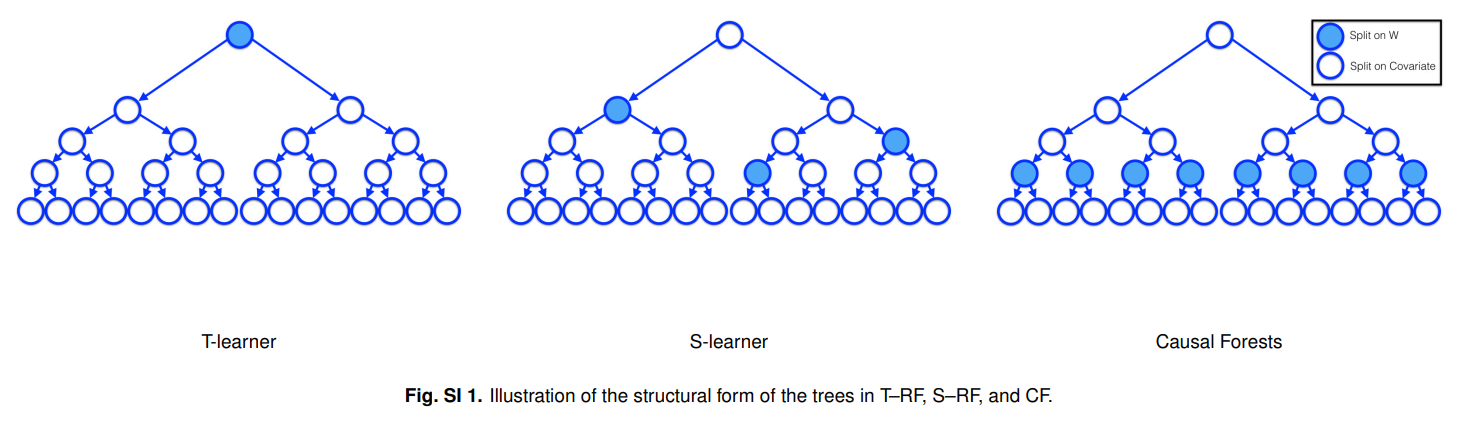

## DA-Learner

[Lechner, T. (2018). Domain Adaptation Under Causal Assumptions (Doctoral dissertation, Eberhard Karls Universität Tübingen Tübingen).](https://toscalechner.github.io/papers/msc-thesis.pdf)

## R-Leaner

- paper: [Nie, X., & Wager, S. (2017). Quasi-oracle estimation of heterogeneous treatment effects. arXiv e-prints. arXiv preprint arXiv:1712.04912.](https://arxiv.org/abs/1712.04912)
- R package: [xnie/rlearner: Quasi-Oracle Estimation of Heterogeneous Treatment Effects](https://github.com/xnie/rlearner)

## 実装

CATENetsパッケージはニューラルネットワークベースのmeta-learnerを簡単に実行できる

[AliciaCurth/CATENets: Sklearn-style implementations of Neural Network-based Conditional Average Treatment Effect (CATE) Estimators.](https://github.com/AliciaCurth/CATENets)

## 応用例

[Case Study #2_ Targeting Optimization_ Bidder at Uber 0812.pdf - Google ドライブ](https://drive.google.com/file/d/1QJJUCo4LH5kGQP3kaJlG1RdhjhaJWp-5/view)

## 参考文献

- [Künzel, et al. (2019). Metalearners for estimating heterogeneous treatment effects using machine learning.](https://www.pnas.org/doi/full/10.1073/pnas.1804597116)
- [機械学習で因果推論\~Meta-LearnerとEconML\~](https://zenn.dev/s1ok69oo/articles/1eeebe75842a50)
- [ITE inference - meta-learners for CATE estimation - YouTube](https://www.youtube.com/watch?v=CkQCwh50SEk&ab_channel=vanderSchaarLab)
    - よくまとまっている講義